*Analitica IETS

In [3]:
import numpy as np
import pandas as pd
import re
import os
import openpyxl
import xlrd
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import shap
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


c:\Users\FranciscoOcampo\Desktop\IETS_challenge\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Lectura de archivos base

In [117]:

municipios_path = r'C:\Users\FranciscoOcampo\Desktop\IETS_challenge\Municipios_post_SQL.xlsx'
prestadores_path = r'C:\Users\FranciscoOcampo\Desktop\IETS_challenge\Prestadores_ajusted.xlsx'


df_municipios = pd.read_excel(municipios_path)
df_prestadores = pd.read_excel(prestadores_path) 


print("Municipios:")
print(df_municipios.head())

print("\nPrestadores:")
print(df_prestadores.head())



Municipios:
   DP Departamento  MPIO    Municipio  Superficie   PopTot  Rural  \
0   5    AntioqUia  5001     Medellín       350.7  2634570    1.6   
1   5    Antioquia  5002   Abejorral        497.6    21622   56.7   
2   5    Antioquia  5004    Abriaquí        287.6     2872   64.2   
3   5    AntioqUia  5021   Alejandría       119.5     4989   40.7   
4   5    Antioquia  5030        Amagá        89.2    32628   47.4   

                 Region  
0  Región Eje Cafetero   
1  Región Eje Cafetero   
2  Región Eje Cafetero   
3  Región Eje Cafetero   
4  Región Eje Cafetero   

Prestadores:
  depa_nombre muni_nombre codigo_habilitacion                nombre_prestador  \
0    Amazonas     LETICIA          9100100148      ALEXANDER ABEL PEREZ FABRA   
1    Amazonas     LETICIA          9100100147         ALICIA PAOLA RUBIO CRUZ   
2    Amazonas     LETICIA          9100100134        ALVARO ENRIQUE LEON LARA   
3    Amazonas     LETICIA          9100100038          ANA LUCIA DIAZ GUEVARA  

Ajuste municipios

In [118]:


import unicodedata
import re

def normalize_text(text):
    text = str(text).strip().lower()
    # Eliminar tildes
    text = unicodedata.normalize('NFKD', text)
    text = ''.join(c for c in text if not unicodedata.combining(c))
    # Reemplazar múltiples espacios por uno
    text = re.sub(r'\s+', ' ', text)

    # Correcciones específicas para casos problemáticos
    text = text.replace('bogota d c', 'bogota')
    text = text.replace('bogota d.c.', 'bogota')
    text = text.replace('bogota d.c', 'bogota')
    text = text.replace('bogota   d   c', 'bogota')
    text = text.replace('bogota dc', 'bogota')
    text = text.replace('San   Andrés   de   Tumaco ', 'tumaco')
    text = text.replace('San Andrés de Tumaco', 'tumaco')
    text = text.replace('San Andrés de   Tumaco', 'tumaco')
    text = text.replace('San Andrés de Tumaco ', 'tumaco')  
    text = text.replace('San Andres de Tumaco', 'tumaco')
    text = text.replace('San Andres de Tumaco', 'tumaco')
    
    return text


    
# Aplicar limpieza a columnas específicas
df_municipios['Departamento'] = df_municipios['Departamento'].apply(normalize_text)
df_municipios['Municipio'] = df_municipios['Municipio'].apply(normalize_text)


In [119]:
def clean_dataframe(df):
    """
    Limpia nombres de columnas y valores tipo texto en el DataFrame.
    """
    # Limpiar nombres de columnas
    df.columns = [normalize_text(col) for col in df.columns]

    # Limpiar valores tipo texto usando apply con función robusta
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].apply(normalize_text)

    return df


# Aplicar limpieza
df_municipios = clean_dataframe(df_municipios)


In [120]:
# Mostrar valores únicos por columna para df_municipios
print("🔎 Valores únicos por columna en df_municipios:\n")
for col in df_municipios.columns:
    print(f"🟩 Columna: {col}")
    print(df_municipios[col].unique())
    print("-" * 50)



🔎 Valores únicos por columna en df_municipios:

🟩 Columna: dp
[ 5  8 11 13 15 17 18 19 20 23 25 27 41 44 47 50 52 54 63 66 68 70 73 76
 81 85 86 88 91 94 95 97 99]
--------------------------------------------------
🟩 Columna: departamento
['antioquia' 'atlantico' 'bogota' 'bolivar' 'boyaca' 'caldas' 'caqueta'
 'cauca' 'cesar' 'cordoba' 'cundinamarca' 'choco' 'huila' 'la guajira'
 'magdalena' 'meta' 'narino' 'norte de santander' 'quindio' 'risaralda'
 'santander' 'sucre' 'tolima' 'valle del cauca' 'arauca' 'casanare'
 'putumayo' 'san andres' 'amazonas' 'guainia' 'guaviare' 'vaupes'
 'vichada']
--------------------------------------------------
🟩 Columna: mpio
[ 5001  5002  5004 ... 99524 99624 99773]
--------------------------------------------------
🟩 Columna: municipio
['medellin' 'abejorral' 'abriaqui' ... 'la primavera' 'santa rosalia'
 'cumaribo']
--------------------------------------------------
🟩 Columna: superficie
[  350.7   497.6   287.6 ... 18188.8  3930.6 64509.4]
---------

In [121]:
df_municipios

,dp,departamento,mpio,municipio,superficie,poptot,rural,region
0,5,antioquia,5001,medellin,350.7,2634570,1.6,region eje cafetero
1,5,antioquia,5002,abejorral,497.6,21622,56.7,region eje cafetero
2,5,antioquia,5004,abriaqui,287.6,2872,64.2,region eje cafetero
3,5,antioquia,5021,alejandria,119.5,4989,40.7,region eje cafetero
4,5,antioquia,5030,amaga,89.2,32628,47.4,region eje cafetero
...,...,...,...,...,...,...,...,...
1113,97,vaupes,97889,yavarate,4791.2,1265,100.0,region llano
1114,99,vichada,99001,puerto carreno,12175.6,22963,23.3,region llano
1115,99,vichada,99524,la primavera,18188.8,11380,38.3,region llano
1116,99,vichada,99624,santa rosalia,3930.6,4732,38.0,region llano


ajustes prestadores

In [122]:
df_prestadores = clean_dataframe(df_prestadores)
df_prestadores['muni_nombre'] = df_prestadores['muni_nombre'].apply(normalize_text)
df_prestadores['depa_nombre'] = df_prestadores['depa_nombre'].apply(normalize_text)

In [123]:
df_prestadores

,depa_nombre,muni_nombre,codigo_habilitacion,nombre_prestador,tido_codigo,nits_nit,razon_social,clpr_codigo,clpr_nombre,ese,...,fecha_corte_reps,telefono_adicional,email_adicional,rep_legal,municipio pdet,municipio zomac,municipio pnis,municipio pnsr antes 2023,municipio pnsr 2023,municipio pnsr 2024
0,amazonas,leticia,9100100148,alexander abel perez fabra,NaN,72291077,alexander abel perez fabra,2,profesional independiente,nan,...,fecha corte reps: may 16 2025 1:34pm,nan,nan,nan,no,no,no,si,si,si
1,amazonas,leticia,9100100147,alicia paola rubio cruz,NaN,1018433478,alicia paola rubio cruz,2,profesional independiente,nan,...,fecha corte reps: may 16 2025 1:34pm,nan,nan,nan,no,no,no,si,si,si
2,amazonas,leticia,9100100134,alvaro enrique leon lara,NaN,13803322,alvaro enrique leon lara,2,profesional independiente,nan,...,fecha corte reps: may 16 2025 1:34pm,nan,nan,nan,no,no,no,si,si,si
3,amazonas,leticia,9100100038,ana lucia diaz guevara,NaN,51782620,ana lucia diaz guevara,2,profesional independiente,no,...,fecha corte reps: may 16 2025 1:34pm,nan,nan,ana lucia diaz guevara,no,no,no,si,si,si
4,amazonas,leticia,9100100107,andres felipe zapata hernandez,NaN,15877110,andres felipe zapata hernandez,2,profesional independiente,nan,...,fecha corte reps: may 16 2025 1:34pm,nan,nan,nan,no,no,no,si,si,si
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59409,vichada,puerto carreno,9900100110,magda liliana toro arias,NaN,21249103,magda liliana toro arias,2,profesional independiente,nan,...,fecha corte reps: may 16 2025 1:34pm,nan,nan,nan,no,no,no,si,si,si
59410,vichada,puerto carreno,9900100049,sandra patricia rojas guerrero,NaN,52030942,sandra patricia rojas guerrero,2,profesional independiente,nan,...,fecha corte reps: may 16 2025 1:34pm,nan,nan,nan,no,no,no,si,si,si
59411,vichada,puerto carreno,9900100153,victoria eugenia mejia villarreal,NaN,55312163,victoria eugenia mejia villarreal,2,profesional independiente,nan,...,fecha corte reps: may 16 2025 1:34pm,3205324136,vickymv@gmail.com,nan,no,no,no,si,si,si
59412,vichada,puerto carreno,9900100119,yafar jose dib bayuelo,NaN,11189583,yafar jose dib bayuelo,2,profesional independiente,nan,...,fecha corte reps: may 16 2025 1:34pm,nan,nan,nan,no,no,no,si,si,si


In [124]:
# Crear nueva columna llamada 'codigo_mpio' a partir de 'codigo_habilitacion'
df_prestadores['mpio'] = df_prestadores['codigo_habilitacion'].astype(str).str[1:5]

df_prestadores


,depa_nombre,muni_nombre,codigo_habilitacion,nombre_prestador,tido_codigo,nits_nit,razon_social,clpr_codigo,clpr_nombre,ese,...,telefono_adicional,email_adicional,rep_legal,municipio pdet,municipio zomac,municipio pnis,municipio pnsr antes 2023,municipio pnsr 2023,municipio pnsr 2024,mpio
0,amazonas,leticia,9100100148,alexander abel perez fabra,NaN,72291077,alexander abel perez fabra,2,profesional independiente,nan,...,nan,nan,nan,no,no,no,si,si,si,1001
1,amazonas,leticia,9100100147,alicia paola rubio cruz,NaN,1018433478,alicia paola rubio cruz,2,profesional independiente,nan,...,nan,nan,nan,no,no,no,si,si,si,1001
2,amazonas,leticia,9100100134,alvaro enrique leon lara,NaN,13803322,alvaro enrique leon lara,2,profesional independiente,nan,...,nan,nan,nan,no,no,no,si,si,si,1001
3,amazonas,leticia,9100100038,ana lucia diaz guevara,NaN,51782620,ana lucia diaz guevara,2,profesional independiente,no,...,nan,nan,ana lucia diaz guevara,no,no,no,si,si,si,1001
4,amazonas,leticia,9100100107,andres felipe zapata hernandez,NaN,15877110,andres felipe zapata hernandez,2,profesional independiente,nan,...,nan,nan,nan,no,no,no,si,si,si,1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59409,vichada,puerto carreno,9900100110,magda liliana toro arias,NaN,21249103,magda liliana toro arias,2,profesional independiente,nan,...,nan,nan,nan,no,no,no,si,si,si,9001
59410,vichada,puerto carreno,9900100049,sandra patricia rojas guerrero,NaN,52030942,sandra patricia rojas guerrero,2,profesional independiente,nan,...,nan,nan,nan,no,no,no,si,si,si,9001
59411,vichada,puerto carreno,9900100153,victoria eugenia mejia villarreal,NaN,55312163,victoria eugenia mejia villarreal,2,profesional independiente,nan,...,3205324136,vickymv@gmail.com,nan,no,no,no,si,si,si,9001
59412,vichada,puerto carreno,9900100119,yafar jose dib bayuelo,NaN,11189583,yafar jose dib bayuelo,2,profesional independiente,nan,...,nan,nan,nan,no,no,no,si,si,si,9001


In [125]:
df_prestadores["clpr_nombre"].unique()

array(['profesional independiente',
       'instituciones prestadoras de servicios de salud - ips',
       'objeto social diferente a la prestacion de servicios de salud',
       'transporte especial de pacientes'], dtype=object)

In [126]:


# Paso 1: Normalizar valores de clpr_nombre
df_prestadores['clpr_nombre'] = df_prestadores['clpr_nombre'].str.strip().str.lower()

# Paso 2: Calcular total de prestadores por municipio y tipo
df_tipo = df_prestadores.groupby(['depa_nombre', 'muni_nombre', 'clpr_nombre']).size().reset_index(name='total_prestadores_mpio')

# Paso 3: Total por departamento para ese tipo de prestador
df_tipo['total_prestadores_dpto'] = df_tipo.groupby(['depa_nombre', 'clpr_nombre'])['total_prestadores_mpio'].transform('sum')

# Paso 4: Mediana por municipio dentro del departamento y tipo
df_tipo['mediana_prestadores_dpto'] = df_tipo.groupby(['depa_nombre', 'clpr_nombre'])['total_prestadores_mpio'].transform('median')

# Paso 5: Diferencia entre municipio y mediana departamental
df_tipo['diferencia_vs_mediana'] = df_tipo['total_prestadores_mpio'] - df_tipo['mediana_prestadores_dpto']

In [127]:
import pandas as pd

# Paso 1: Normalizar valores de clpr_nombre
df_prestadores['clpr_nombre'] = df_prestadores['clpr_nombre'].str.strip().str.lower()

# Paso 2: Calcular total de prestadores por municipio y tipo (base para merge)
df_agg = (
    df_prestadores
    .groupby(['depa_nombre', 'muni_nombre', 'clpr_nombre'])
    .size()
    .reset_index(name='total_prestadores_mpio')
)

# Paso 3: Total y mediana por departamento para ese tipo
df_agg['total_prestadores_dpto'] = df_agg.groupby(['depa_nombre', 'clpr_nombre'])['total_prestadores_mpio'].transform('sum')
df_agg['mediana_prestadores_dpto'] = df_agg.groupby(['depa_nombre', 'clpr_nombre'])['total_prestadores_mpio'].transform('median')
df_agg['diferencia_vs_mediana'] = df_agg['total_prestadores_mpio'] - df_agg['mediana_prestadores_dpto']

# Paso 4: Merge con la base original para mantener trazabilidad
df_tipo = pd.merge(
    df_prestadores,
    df_agg,
    how='left',
    on=['depa_nombre', 'muni_nombre', 'clpr_nombre']
)



In [128]:
from rapidfuzz import process, fuzz

# Extraer listas únicas de municipios de cada DataFrame
nombres_tipo = df_tipo['muni_nombre'].dropna().unique()
nombres_muni = df_municipios['municipio'].dropna().unique()

# Crear tabla con matches aproximados
resultados_fuzzy = []

for nombre in nombres_tipo:
    mejor_match, score, _ = process.extractOne(nombre, nombres_muni, scorer=fuzz.ratio)
    if score < 100:  # Solo mostrar si no es match perfecto
        resultados_fuzzy.append({
            'muni_nombre_df_tipo': nombre,
            'mejor_match_df_municipios': mejor_match,
            'similitud': score
        })

# Convertir a DataFrame para análisis
df_fuzzy = pd.DataFrame(resultados_fuzzy).sort_values(by='similitud', ascending=False)
df_fuzzy 

,muni_nombre_df_tipo,mejor_match_df_municipios,similitud
7,vistahermosa,vista hermosa,96.000000
6,puebloviejo,pueblo viejo,95.652174
14,rioblanco,rio blanco,94.736842
8,chachagui,chachagi,94.117647
11,valle del guamuez,valle de guamez,93.750000
4,dibulla,dibula,92.307692
0,guican,gican,90.909091
12,guepsa,gepsa,90.909091
9,magui,magi,88.888889
1,togui,togi,88.888889


In [129]:
# Paso 1: Filtrar solo los casos con alta similitud para corregir
df_fuzzy_filtrado = df_fuzzy[df_fuzzy['similitud'] >= 70]

# Paso 2: Crear diccionario de reemplazo
reemplazos = dict(zip(df_fuzzy_filtrado['muni_nombre_df_tipo'], df_fuzzy_filtrado['mejor_match_df_municipios']))

# Paso 3: Aplicar corrección sobre df_tipo
df_tipo['muni_nombre'] = df_tipo['muni_nombre'].replace(reemplazos)

In [130]:
#pruebajoin municipio
# Paso 1: Asegurarse que ambas columnas clave se llaman igual y están limpias
df_municipios['mpio'] = df_municipios['mpio'].astype(str).str.strip()
df_tipo['mpio'] = df_tipo['mpio'].astype(str).str.strip()

# Paso 2: Hacer el join (left join desde df_tipo para conservar trazabilidad del prestador)

df_tipo_joined = pd.merge(
    df_tipo,
    df_municipios,
    how='left',
    left_on='muni_nombre',
    right_on='municipio',
    suffixes=('', '_muni')
)


# Paso 3: Verificar cuántos registros cruzaron bien (sin nulos)
num_total = len(df_tipo_joined)
num_matched = df_tipo_joined['departamento'].notna().sum()

print(f"🔎 Total registros en df_tipo: {num_total}")
print(f"✅ Registros que cruzaron exitosamente con df_municipios: {num_matched}")
print(f"❌ Registros sin cruce (nulos): {num_total - num_matched}")



🔎 Total registros en df_tipo: 63144
✅ Registros que cruzaron exitosamente con df_municipios: 63144
❌ Registros sin cruce (nulos): 0


In [131]:
df_tipo_joined.columns

Index(['depa_nombre', 'muni_nombre', 'codigo_habilitacion', 'nombre_prestador',
       'tido_codigo', 'nits_nit', 'razon_social', 'clpr_codigo', 'clpr_nombre',
       'ese', 'direccion', 'telefono', 'fax', 'email', 'gerente', 'nivel',
       'caracter', 'habilitado', 'fecha_radicacion', 'fecha_vencimiento',
       'fecha_cierre', 'dv', 'clase_persona', 'naju_codigo', 'naju_nombre',
       'numero_sede_principal', 'fecha_corte_reps', 'telefono_adicional',
       'email_adicional', 'rep_legal', 'municipio pdet', 'municipio zomac',
       'municipio pnis', 'municipio pnsr antes 2023', 'municipio pnsr 2023',
       'municipio pnsr 2024', 'mpio', 'total_prestadores_mpio',
       'total_prestadores_dpto', 'mediana_prestadores_dpto',
       'diferencia_vs_mediana', 'dp', 'departamento', 'mpio_muni', 'municipio',
       'superficie', 'poptot', 'rural', 'region'],
      dtype='object')

In [132]:
df_tipo_joined[['mpio','muni_nombre', 'clpr_nombre','total_prestadores_mpio', "poptot"]].head(10)

,mpio,muni_nombre,clpr_nombre,total_prestadores_mpio,poptot
0,1001,leticia,profesional independiente,43,55691
1,1001,leticia,profesional independiente,43,55691
2,1001,leticia,profesional independiente,43,55691
3,1001,leticia,profesional independiente,43,55691
4,1001,leticia,profesional independiente,43,55691
5,1001,leticia,profesional independiente,43,55691
6,1001,leticia,profesional independiente,43,55691
7,1001,leticia,profesional independiente,43,55691
8,1001,leticia,profesional independiente,43,55691
9,1001,leticia,instituciones prestadoras de servicios de salu...,12,55691


In [133]:
df_tipo_joined["prestadores_x_10mil_hab"] = df_tipo_joined["total_prestadores_mpio"] / (df_tipo_joined["poptot"] / 10000)
df_tipo_joined["prestadores_x_100km2"] = df_tipo_joined["total_prestadores_mpio"] / (df_tipo_joined["superficie"] /100)
df_tipo_joined

,depa_nombre,muni_nombre,codigo_habilitacion,nombre_prestador,tido_codigo,nits_nit,razon_social,clpr_codigo,clpr_nombre,ese,...,dp,departamento,mpio_muni,municipio,superficie,poptot,rural,region,prestadores_x_10mil_hab,prestadores_x_100km2
0,amazonas,leticia,9100100148,alexander abel perez fabra,NaN,72291077,alexander abel perez fabra,2,profesional independiente,nan,...,91,amazonas,91001,leticia,5717.7,55691,27.3,region centro sur,7.721176,0.752051
1,amazonas,leticia,9100100147,alicia paola rubio cruz,NaN,1018433478,alicia paola rubio cruz,2,profesional independiente,nan,...,91,amazonas,91001,leticia,5717.7,55691,27.3,region centro sur,7.721176,0.752051
2,amazonas,leticia,9100100134,alvaro enrique leon lara,NaN,13803322,alvaro enrique leon lara,2,profesional independiente,nan,...,91,amazonas,91001,leticia,5717.7,55691,27.3,region centro sur,7.721176,0.752051
3,amazonas,leticia,9100100038,ana lucia diaz guevara,NaN,51782620,ana lucia diaz guevara,2,profesional independiente,no,...,91,amazonas,91001,leticia,5717.7,55691,27.3,region centro sur,7.721176,0.752051
4,amazonas,leticia,9100100107,andres felipe zapata hernandez,NaN,15877110,andres felipe zapata hernandez,2,profesional independiente,nan,...,91,amazonas,91001,leticia,5717.7,55691,27.3,region centro sur,7.721176,0.752051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63139,vichada,puerto carreno,9900100110,magda liliana toro arias,NaN,21249103,magda liliana toro arias,2,profesional independiente,nan,...,99,vichada,99001,puerto carreno,12175.6,22963,23.3,region llano,8.709663,0.164263
63140,vichada,puerto carreno,9900100049,sandra patricia rojas guerrero,NaN,52030942,sandra patricia rojas guerrero,2,profesional independiente,nan,...,99,vichada,99001,puerto carreno,12175.6,22963,23.3,region llano,8.709663,0.164263
63141,vichada,puerto carreno,9900100153,victoria eugenia mejia villarreal,NaN,55312163,victoria eugenia mejia villarreal,2,profesional independiente,nan,...,99,vichada,99001,puerto carreno,12175.6,22963,23.3,region llano,8.709663,0.164263
63142,vichada,puerto carreno,9900100119,yafar jose dib bayuelo,NaN,11189583,yafar jose dib bayuelo,2,profesional independiente,nan,...,99,vichada,99001,puerto carreno,12175.6,22963,23.3,region llano,8.709663,0.164263


In [134]:
df_tipo_joined[['mpio','muni_nombre', 'clpr_nombre','total_prestadores_mpio', "poptot","prestadores_x_10mil_hab","prestadores_x_100km2",'superficie']]


,mpio,muni_nombre,clpr_nombre,total_prestadores_mpio,poptot,prestadores_x_10mil_hab,prestadores_x_100km2,superficie
0,1001,leticia,profesional independiente,43,55691,7.721176,0.752051,5717.7
1,1001,leticia,profesional independiente,43,55691,7.721176,0.752051,5717.7
2,1001,leticia,profesional independiente,43,55691,7.721176,0.752051,5717.7
3,1001,leticia,profesional independiente,43,55691,7.721176,0.752051,5717.7
4,1001,leticia,profesional independiente,43,55691,7.721176,0.752051,5717.7
...,...,...,...,...,...,...,...,...
63139,9001,puerto carreno,profesional independiente,20,22963,8.709663,0.164263,12175.6
63140,9001,puerto carreno,profesional independiente,20,22963,8.709663,0.164263,12175.6
63141,9001,puerto carreno,profesional independiente,20,22963,8.709663,0.164263,12175.6
63142,9001,puerto carreno,profesional independiente,20,22963,8.709663,0.164263,12175.6


In [135]:
variables = ['prestadores_x_10mil_hab', 'prestadores_x_100km2', 'diferencia_vs_mediana']

# —————————————————————————————————————————————————————————
# Paso 1: Asegurarnos de que no haya nulos (los tratamos como 0)
# —————————————————————————————————————————————————————————
# df_tipo_joined[variables] = df_tipo_joined[variables].fillna(0)

# —————————————————————————————————————————————————————————
# Paso 2: Función para asignar puntaje según cuartiles dentro de cada clpr_nombre
# —————————————————————————————————————————————————————————
def asignar_puntaje_cuartil(s: pd.Series) -> pd.Series:
    pct = s.rank(method='max', pct=True)  # percentil dentro del grupo
    bins   = [0.0, 0.25, 0.50, 0.75, 1.00]
    labels = [0, 5, 10, 15]
    # convierto percentiles en 4 categorías fijas
    return pd.cut(pct, bins=bins, labels=labels, include_lowest=True).astype(int)

# —————————————————————————————————————————————————————————
# Paso 3: Aplicar la función por cada 'clpr_nombre' y cada variable
# —————————————————————————————————————————————————————————
for var in variables:
    df_tipo_joined[f'puntaje_{var}'] = (
        df_tipo_joined
        .groupby('clpr_nombre')[var]
        .transform(asignar_puntaje_cuartil)
    )

# —————————————————————————————————————————————————————————
# Paso 4: Sumar los puntajes de las 3 variables en 'puntaje_total'
# —————————————————————————————————————————————————————————
cols_puntajes = [f'puntaje_{var}' for var in variables]
df_tipo_joined['puntaje_total'] = df_tipo_joined[cols_puntajes].sum(axis=1)

# —————————————————————————————————————————————————————————
# Paso 5: Calcular promedio de puntaje_total por municipio
# —————————————————————————————————————————————————————————
df_puntaje_municipal = (
    df_tipo_joined
    .groupby('muni_nombre', as_index=False)['puntaje_total']
    .mean()
    .rename(columns={'puntaje_total': 'puntaje_promedio'})
)

# —————————————————————————————————————————————————————————
# Paso 6: Clasificar cobertura municipal en 4 niveles (cuartiles)
# —————————————————————————————————————————————————————————
labels_cobertura = [
    'Cobertura baja',
    'Cobertura media baja',
    'Cobertura media alta',
    'Cobertura alta'
]
df_puntaje_municipal['clasificacion_cobertura'] = pd.qcut(
    df_puntaje_municipal['puntaje_promedio'],
    q=4,
    labels=labels_cobertura,
    duplicates='drop'
)

# —————————————————————————————————————————————————————————
# Paso 7: Unir de vuelta la clasificación municipal al DataFrame original
# —————————————————————————————————————————————————————————
df_tipo_joined = df_tipo_joined.merge(
    df_puntaje_municipal[['muni_nombre', 'puntaje_promedio', 'clasificacion_cobertura']],
    on='muni_nombre',
    how='left'
)

# —————————————————————————————————————————————————————————
# Paso 8: Promedio de puntaje_total por cada clpr_nombre y municipio
# —————————————————————————————————————————————————————————
df_puntaje_clpr_muni = (
    df_tipo_joined
    .groupby(['clpr_nombre', 'muni_nombre'], as_index=False)['puntaje_total']
    .mean()
    .rename(columns={'puntaje_total': 'puntaje_promedio_clpr'})
)

# —————————————————————————————————————————————————————————
# Paso 9: Clasificar cobertura de cada municipio dentro de su clpr_nombre
# —————————————————————————————————————————————————————————
# Usamos percentil + pd.cut en lugar de qcut para evitar errores de bins insuficientes
df_puntaje_clpr_muni['clasificacion_cobertura_clpr'] = (
    df_puntaje_clpr_muni
    .groupby('clpr_nombre')['puntaje_promedio_clpr']
    .transform(lambda s: pd.cut(
        s.rank(method='max', pct=True),
        bins=[0.0, 0.25, 0.50, 0.75, 1.00],
        labels=labels_cobertura,
        include_lowest=True
    ))
)

# —————————————————————————————————————————————————————————
# Paso 10: Unir la clasificación por clpr_nombre y municipio al DataFrame original
# —————————————————————————————————————————————————————————
df_tipo_joined = df_tipo_joined.merge(
    df_puntaje_clpr_muni[
        ['clpr_nombre', 'muni_nombre', 
         'puntaje_promedio_clpr', 'clasificacion_cobertura_clpr']
    ],
    on=['clpr_nombre', 'muni_nombre'],
    how='left'
)

In [136]:
df_tipo_joined

,depa_nombre,muni_nombre,codigo_habilitacion,nombre_prestador,tido_codigo,nits_nit,razon_social,clpr_codigo,clpr_nombre,ese,...,prestadores_x_10mil_hab,prestadores_x_100km2,puntaje_prestadores_x_10mil_hab,puntaje_prestadores_x_100km2,puntaje_diferencia_vs_mediana,puntaje_total,puntaje_promedio,clasificacion_cobertura,puntaje_promedio_clpr,clasificacion_cobertura_clpr
0,amazonas,leticia,9100100148,alexander abel perez fabra,NaN,72291077,alexander abel perez fabra,2,profesional independiente,nan,...,7.721176,0.752051,0,0,5,5,6.22807,Cobertura media alta,5.0,Cobertura alta
1,amazonas,leticia,9100100147,alicia paola rubio cruz,NaN,1018433478,alicia paola rubio cruz,2,profesional independiente,nan,...,7.721176,0.752051,0,0,5,5,6.22807,Cobertura media alta,5.0,Cobertura alta
2,amazonas,leticia,9100100134,alvaro enrique leon lara,NaN,13803322,alvaro enrique leon lara,2,profesional independiente,nan,...,7.721176,0.752051,0,0,5,5,6.22807,Cobertura media alta,5.0,Cobertura alta
3,amazonas,leticia,9100100038,ana lucia diaz guevara,NaN,51782620,ana lucia diaz guevara,2,profesional independiente,no,...,7.721176,0.752051,0,0,5,5,6.22807,Cobertura media alta,5.0,Cobertura alta
4,amazonas,leticia,9100100107,andres felipe zapata hernandez,NaN,15877110,andres felipe zapata hernandez,2,profesional independiente,nan,...,7.721176,0.752051,0,0,5,5,6.22807,Cobertura media alta,5.0,Cobertura alta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63139,vichada,puerto carreno,9900100110,magda liliana toro arias,NaN,21249103,magda liliana toro arias,2,profesional independiente,nan,...,8.709663,0.164263,0,0,5,5,5.00000,Cobertura media baja,5.0,Cobertura alta
63140,vichada,puerto carreno,9900100049,sandra patricia rojas guerrero,NaN,52030942,sandra patricia rojas guerrero,2,profesional independiente,nan,...,8.709663,0.164263,0,0,5,5,5.00000,Cobertura media baja,5.0,Cobertura alta
63141,vichada,puerto carreno,9900100153,victoria eugenia mejia villarreal,NaN,55312163,victoria eugenia mejia villarreal,2,profesional independiente,nan,...,8.709663,0.164263,0,0,5,5,5.00000,Cobertura media baja,5.0,Cobertura alta
63142,vichada,puerto carreno,9900100119,yafar jose dib bayuelo,NaN,11189583,yafar jose dib bayuelo,2,profesional independiente,nan,...,8.709663,0.164263,0,0,5,5,5.00000,Cobertura media baja,5.0,Cobertura alta


In [137]:
conteo_cobertura = df_tipo_joined['clasificacion_cobertura'].value_counts().reset_index()
conteo_cobertura.columns = ['clasificacion_cobertura', 'cantidad']
conteo_cobertura

,clasificacion_cobertura,cantidad
0,Cobertura alta,56995
1,Cobertura media baja,3293
2,Cobertura media alta,1907
3,Cobertura baja,949


In [138]:

df_tipo_joined.groupby('clasificacion_cobertura')['muni_nombre'] \
             .nunique() \
             .sort_index() \
             .rename("n_municipios") \
             .reset_index()

C:\Users\FranciscoOcampo\AppData\Local\Temp\ipykernel_12080\3873072813.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_tipo_joined.groupby('clasificacion_cobertura')['muni_nombre'] \


,clasificacion_cobertura,n_municipios
0,Cobertura baja,282
1,Cobertura media baja,316
2,Cobertura media alta,86
3,Cobertura alta,228


In [139]:
df_tipo_joined.groupby(['clasificacion_cobertura', 'clasificacion_cobertura_clpr'])['muni_nombre'] \
             .nunique() \
             .sort_index() \
             .rename("n_municipios") \
             .reset_index()

C:\Users\FranciscoOcampo\AppData\Local\Temp\ipykernel_12080\632836872.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_tipo_joined.groupby(['clasificacion_cobertura', 'clasificacion_cobertura_clpr'])['muni_nombre'] \


,clasificacion_cobertura,clasificacion_cobertura_clpr,n_municipios
0,Cobertura baja,Cobertura baja,116
1,Cobertura baja,Cobertura media baja,236
2,Cobertura baja,Cobertura media alta,123
3,Cobertura baja,Cobertura alta,5
4,Cobertura media baja,Cobertura baja,49
5,Cobertura media baja,Cobertura media baja,71
6,Cobertura media baja,Cobertura media alta,267
7,Cobertura media baja,Cobertura alta,202
8,Cobertura media alta,Cobertura baja,15
9,Cobertura media alta,Cobertura media baja,34


In [140]:
conteo_cobertura = df_tipo_joined['puntaje_total'].value_counts().reset_index()
conteo_cobertura.columns = ['puntaje_total', 'cantidad']
conteo_cobertura

,puntaje_total,cantidad
0,30,17177
1,25,8759
2,45,7101
3,5,6291
4,20,5816
5,35,5134
6,15,4982
7,10,4877
8,40,1789
9,0,1218


In [141]:
df_tipo_joined['densidad_poblacional'] = df_tipo_joined['poptot'] / df_tipo_joined['superficie']

# Clasificar por cuartiles de densidad
labels_densidad = ['Baja densidad', 'Media baja', 'Media alta', 'Alta densidad']
df_tipo_joined['clasificacion_densidad'] = pd.qcut(
    df_tipo_joined['densidad_poblacional'],
    q=4,
    labels=labels_densidad,
    duplicates='drop'
)

In [142]:
conteo_densidad = df_tipo_joined['clasificacion_densidad'].value_counts().reset_index()
conteo_densidad.columns = ['clasificacion_densidad', 'cantidad']
conteo_densidad

,clasificacion_densidad,cantidad
0,Media alta,20915
1,Media baja,16503
2,Baja densidad,15794
3,Alta densidad,9932


In [143]:
df_tipo_joined.columns


Index(['depa_nombre', 'muni_nombre', 'codigo_habilitacion', 'nombre_prestador',
       'tido_codigo', 'nits_nit', 'razon_social', 'clpr_codigo', 'clpr_nombre',
       'ese', 'direccion', 'telefono', 'fax', 'email', 'gerente', 'nivel',
       'caracter', 'habilitado', 'fecha_radicacion', 'fecha_vencimiento',
       'fecha_cierre', 'dv', 'clase_persona', 'naju_codigo', 'naju_nombre',
       'numero_sede_principal', 'fecha_corte_reps', 'telefono_adicional',
       'email_adicional', 'rep_legal', 'municipio pdet', 'municipio zomac',
       'municipio pnis', 'municipio pnsr antes 2023', 'municipio pnsr 2023',
       'municipio pnsr 2024', 'mpio', 'total_prestadores_mpio',
       'total_prestadores_dpto', 'mediana_prestadores_dpto',
       'diferencia_vs_mediana', 'dp', 'departamento', 'mpio_muni', 'municipio',
       'superficie', 'poptot', 'rural', 'region', 'prestadores_x_10mil_hab',
       'prestadores_x_100km2', 'puntaje_prestadores_x_10mil_hab',
       'puntaje_prestadores_x_100km2', '

In [144]:
df_tipo_joined

,depa_nombre,muni_nombre,codigo_habilitacion,nombre_prestador,tido_codigo,nits_nit,razon_social,clpr_codigo,clpr_nombre,ese,...,puntaje_prestadores_x_10mil_hab,puntaje_prestadores_x_100km2,puntaje_diferencia_vs_mediana,puntaje_total,puntaje_promedio,clasificacion_cobertura,puntaje_promedio_clpr,clasificacion_cobertura_clpr,densidad_poblacional,clasificacion_densidad
0,amazonas,leticia,9100100148,alexander abel perez fabra,NaN,72291077,alexander abel perez fabra,2,profesional independiente,nan,...,0,0,5,5,6.22807,Cobertura media alta,5.0,Cobertura alta,9.740105,Baja densidad
1,amazonas,leticia,9100100147,alicia paola rubio cruz,NaN,1018433478,alicia paola rubio cruz,2,profesional independiente,nan,...,0,0,5,5,6.22807,Cobertura media alta,5.0,Cobertura alta,9.740105,Baja densidad
2,amazonas,leticia,9100100134,alvaro enrique leon lara,NaN,13803322,alvaro enrique leon lara,2,profesional independiente,nan,...,0,0,5,5,6.22807,Cobertura media alta,5.0,Cobertura alta,9.740105,Baja densidad
3,amazonas,leticia,9100100038,ana lucia diaz guevara,NaN,51782620,ana lucia diaz guevara,2,profesional independiente,no,...,0,0,5,5,6.22807,Cobertura media alta,5.0,Cobertura alta,9.740105,Baja densidad
4,amazonas,leticia,9100100107,andres felipe zapata hernandez,NaN,15877110,andres felipe zapata hernandez,2,profesional independiente,nan,...,0,0,5,5,6.22807,Cobertura media alta,5.0,Cobertura alta,9.740105,Baja densidad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63139,vichada,puerto carreno,9900100110,magda liliana toro arias,NaN,21249103,magda liliana toro arias,2,profesional independiente,nan,...,0,0,5,5,5.00000,Cobertura media baja,5.0,Cobertura alta,1.885985,Baja densidad
63140,vichada,puerto carreno,9900100049,sandra patricia rojas guerrero,NaN,52030942,sandra patricia rojas guerrero,2,profesional independiente,nan,...,0,0,5,5,5.00000,Cobertura media baja,5.0,Cobertura alta,1.885985,Baja densidad
63141,vichada,puerto carreno,9900100153,victoria eugenia mejia villarreal,NaN,55312163,victoria eugenia mejia villarreal,2,profesional independiente,nan,...,0,0,5,5,5.00000,Cobertura media baja,5.0,Cobertura alta,1.885985,Baja densidad
63142,vichada,puerto carreno,9900100119,yafar jose dib bayuelo,NaN,11189583,yafar jose dib bayuelo,2,profesional independiente,nan,...,0,0,5,5,5.00000,Cobertura media baja,5.0,Cobertura alta,1.885985,Baja densidad


***Mineria de datos con machine learning no supervisado***

**Clustering  -  PCA**

In [164]:
# Eliminar columnas irrelevantes para modelado (nombres, IDs, contacto, fechas, categóricas duplicadas o redundantes)
columns_to_drop = [
    'depa_nombre', 'codigo_habilitacion', 'nombre_prestador', 'tido_codigo', 'nits_nit',
    'razon_social', 'clpr_codigo', 'ese', 'direccion', 'telefono', 'fax',
    'email', 'gerente',  'habilitado', 'fecha_radicacion',"dp",
    'fecha_vencimiento', 'fecha_cierre', 'dv', 'naju_codigo',
    'numero_sede_principal', 'fecha_corte_reps', 'telefono_adicional', 'email_adicional',
    'rep_legal', 'departamento', 'mpio_muni', 'municipio', 'region','mpio'
]
# Filtrar columnas que no están en columns_to_drop
df_model = df_tipo_joined.drop(columns=[col for col in df_tipo_joined.columns if col in columns_to_drop])

# Separar numéricas y categóricas
numeric_cols = df_model.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [col for col in df_model.columns if col not in numeric_cols + ['muni_nombre', 'clpr_nombre']]

# Agrupar por municipio y clpr_nombre, calcular promedio de numéricas y moda de categóricas
df_num = df_model.groupby(['muni_nombre', ], as_index=False)[numeric_cols].mean()
df_cat = df_model.groupby(['muni_nombre', ], as_index=False)[categorical_cols].agg(lambda x: x.mode().iloc[0])

# Unir ambos
df_model_final = pd.merge(df_num, df_cat, on=['muni_nombre'], how='left')

In [165]:
df_model_final

,muni_nombre,nivel,total_prestadores_mpio,total_prestadores_dpto,mediana_prestadores_dpto,diferencia_vs_mediana,superficie,poptot,rural,prestadores_x_10mil_hab,...,naju_nombre,municipio pdet,municipio zomac,municipio pnis,municipio pnsr antes 2023,municipio pnsr 2023,municipio pnsr 2024,clasificacion_cobertura,clasificacion_cobertura_clpr,clasificacion_densidad
0,abejorral,1.0,9.461538,8677.846154,7.000000,2.461538,497.6,21622.0,56.7,4.375885,...,privada,no,si,no,no,si,si,Cobertura media alta,Cobertura alta,Baja densidad
1,abrego,1.0,8.384615,1060.230769,2.769231,5.615385,1507.4,36177.0,47.3,2.317665,...,privada,no,no,si,no,si,no,Cobertura media baja,Cobertura alta,Baja densidad
2,acacias,1.0,53.769231,511.923077,2.615385,51.153846,1086.4,97925.0,24.4,5.490858,...,privada,no,no,no,no,no,no,Cobertura alta,Cobertura alta,Baja densidad
3,acandi,NaN,1.000000,115.000000,1.250000,-0.250000,800.7,16096.0,56.1,0.621272,...,privada,si,si,si,si,si,si,Cobertura baja,Cobertura baja,Baja densidad
4,acevedo,1.0,3.400000,749.000000,3.400000,0.000000,537.1,27418.0,82.4,1.240061,...,privada,no,si,no,no,si,si,Cobertura media baja,Cobertura alta,Baja densidad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,zaragoza,NaN,7.222222,9119.666667,7.222222,0.000000,1277.4,26392.0,49.1,2.736519,...,privada,si,si,si,si,si,si,Cobertura media baja,Cobertura alta,Baja densidad
908,zarzal,2.0,18.696970,1006.878788,7.424242,11.272727,365.9,43252.0,22.8,4.322799,...,privada,no,no,no,no,no,no,Cobertura media alta,Cobertura alta,Baja densidad
909,zetaquira,1.0,1.000000,779.000000,1.500000,-0.500000,226.7,4996.0,70.6,2.001601,...,privada,no,no,no,no,si,no,Cobertura media baja,Cobertura media baja,Baja densidad
910,zipaquira,2.0,136.403315,1985.917127,5.370166,131.033149,204.9,165473.0,14.5,8.243237,...,privada,no,no,no,no,no,no,Cobertura alta,Cobertura alta,Media baja


In [166]:
df_model_final.columns

Index(['muni_nombre', 'nivel', 'total_prestadores_mpio',
       'total_prestadores_dpto', 'mediana_prestadores_dpto',
       'diferencia_vs_mediana', 'superficie', 'poptot', 'rural',
       'prestadores_x_10mil_hab', 'prestadores_x_100km2',
       'puntaje_prestadores_x_10mil_hab', 'puntaje_prestadores_x_100km2',
       'puntaje_diferencia_vs_mediana', 'puntaje_total', 'puntaje_promedio',
       'puntaje_promedio_clpr', 'densidad_poblacional', 'caracter',
       'clase_persona', 'naju_nombre', 'municipio pdet', 'municipio zomac',
       'municipio pnis', 'municipio pnsr antes 2023', 'municipio pnsr 2023',
       'municipio pnsr 2024', 'clasificacion_cobertura',
       'clasificacion_cobertura_clpr', 'clasificacion_densidad'],
      dtype='object')

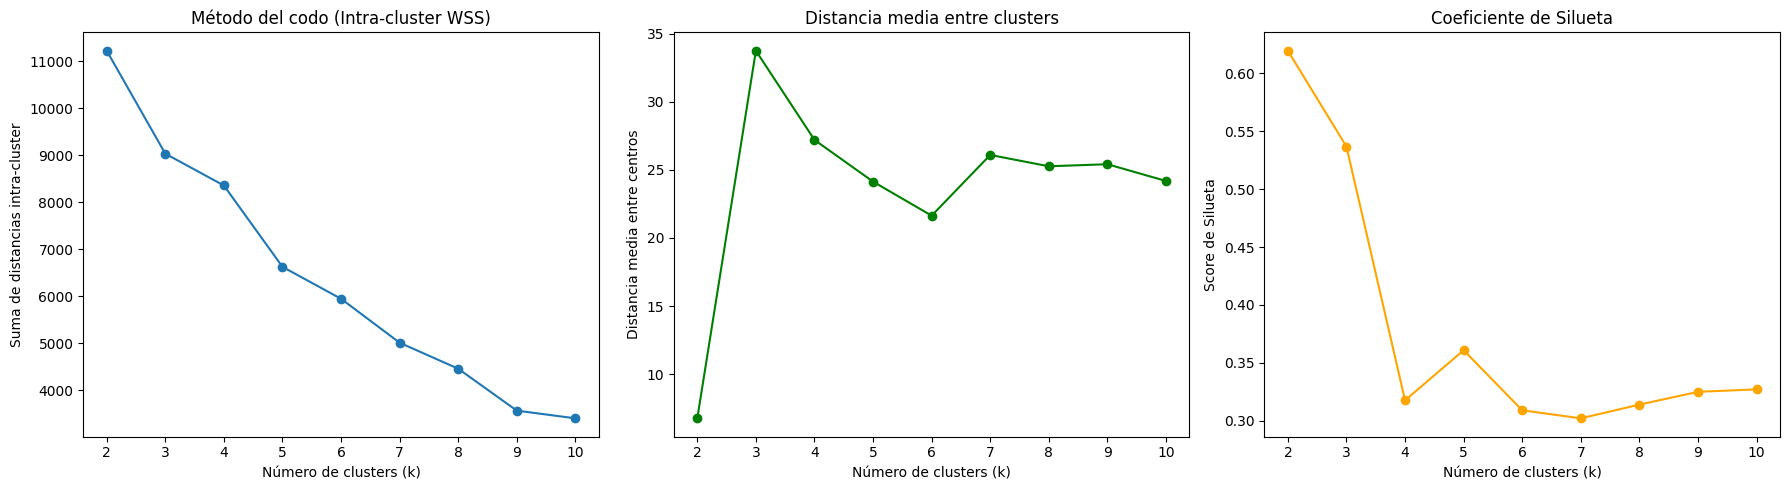

In [167]:
# Selección de variables numéricas relevantes para clustering
# Se excluyen variables categóricas como 'nivel', 'caracter', 'clpr_nombre', 'clasificacion_*'
categorical_vars = ['muni_nombre', 'clpr_nombre', 'nivel', 'caracter',
                    'clasificacion_cobertura', 'clasificacion_densidad']
cluster_vars = [col for col in df_model_final.columns if col not in categorical_vars and df_model_final[col].dtype in [np.float64, np.int64]]

X = df_model_final[cluster_vars].dropna()

# Estandarizar variables para evitar sesgo por escalas distintas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Inicializar listas para almacenar resultados
inertia = []           # intra-cluster distances (WSS)
inter_cluster_dist = []  # inter-cluster distances
silhouette_scores = []  # silhouette scores
k_values = range(2, 11)

# Evaluación para distintos valores de K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    
    inertia.append(kmeans.inertia_)
    
    # Inter-cluster distance = mean distance between cluster centers
    centers = kmeans.cluster_centers_
    center_dists = np.mean([np.linalg.norm(c1 - c2) for i, c1 in enumerate(centers) for j, c2 in enumerate(centers) if i < j])
    inter_cluster_dist.append(center_dists)
    
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil_score)

# Graficar resultados
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot(k_values, inertia, marker='o')
axs[0].set_title('Método del codo (Intra-cluster WSS)')
axs[0].set_xlabel('Número de clusters (k)')
axs[0].set_ylabel('Suma de distancias intra-cluster')

axs[1].plot(k_values, inter_cluster_dist, marker='o', color='green')
axs[1].set_title('Distancia media entre clusters')
axs[1].set_xlabel('Número de clusters (k)')
axs[1].set_ylabel('Distancia media entre centros')

axs[2].plot(k_values, silhouette_scores, marker='o', color='orange')
axs[2].set_title('Coeficiente de Silueta')
axs[2].set_xlabel('Número de clusters (k)')
axs[2].set_ylabel('Score de Silueta')

plt.tight_layout()
plt.show()

1-Intra clusters: -Aquí parece haber un quiebre o codo alrededor de k = 3, después del cual la ganancia de agrupar más se vuelve marginal.
2-Distancia media entre clusters : Observas el máximo pico en k = 3, lo que sugiere que los centros están bien separados allí, antes de comenzar a acercarse entre ellos.
3-silueta: k = 2 y 3 tienen los mejores scores (0.52 a 0.51).


**la mejor agrupación son 3 clusters**


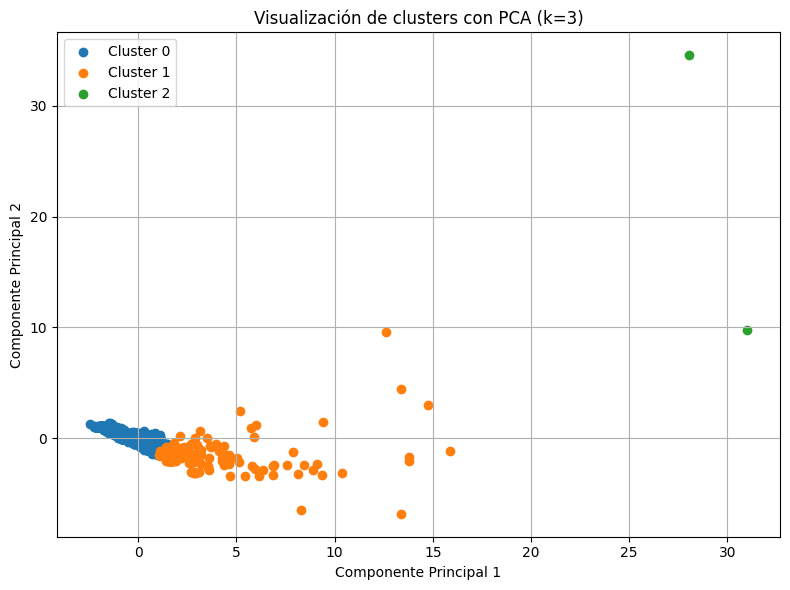

In [168]:
from sklearn.decomposition import PCA

# Entrenar modelo final con KMeans con k=4
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Agregar etiquetas de cluster al DataFrame original (solo con variables numéricas)
df_clustered = df_model_final.copy()
df_clustered['cluster'] = cluster_labels

# Aplicar PCA para reducir a 2D para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_clustered['PCA1'] = X_pca[:, 0]
df_clustered['PCA2'] = X_pca[:, 1]

# Graficar clusters en 2D
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.scatter(
        df_clustered[df_clustered['cluster'] == i]['PCA1'],
        df_clustered[df_clustered['cluster'] == i]['PCA2'],
        label=f'Cluster {i}'
    )
plt.title('Visualización de clusters con PCA (k=3)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [169]:
# Seleccionar columnas clave para el merge
cluster_labels_df = df_clustered[['muni_nombre',  'cluster']]

# Hacer merge con df_tipo_joined
df_tipo_joined_clustered = df_tipo_joined.merge(
    cluster_labels_df,
    how='left',
    on=['muni_nombre']
)



In [170]:
conteo_cluster = df_tipo_joined_clustered['cluster'].value_counts().reset_index()
conteo_cluster.columns = ['cluster', 'cantidad']
conteo_cluster

,cluster,cantidad
0,1,33392
1,2,21142
2,0,8610


In [171]:
df_tipo_joined_clustered

,depa_nombre,muni_nombre,codigo_habilitacion,nombre_prestador,tido_codigo,nits_nit,razon_social,clpr_codigo,clpr_nombre,ese,...,puntaje_prestadores_x_100km2,puntaje_diferencia_vs_mediana,puntaje_total,puntaje_promedio,clasificacion_cobertura,puntaje_promedio_clpr,clasificacion_cobertura_clpr,densidad_poblacional,clasificacion_densidad,cluster
0,amazonas,leticia,9100100148,alexander abel perez fabra,NaN,72291077,alexander abel perez fabra,2,profesional independiente,nan,...,0,5,5,6.22807,Cobertura media alta,5.0,Cobertura alta,9.740105,Baja densidad,0
1,amazonas,leticia,9100100147,alicia paola rubio cruz,NaN,1018433478,alicia paola rubio cruz,2,profesional independiente,nan,...,0,5,5,6.22807,Cobertura media alta,5.0,Cobertura alta,9.740105,Baja densidad,0
2,amazonas,leticia,9100100134,alvaro enrique leon lara,NaN,13803322,alvaro enrique leon lara,2,profesional independiente,nan,...,0,5,5,6.22807,Cobertura media alta,5.0,Cobertura alta,9.740105,Baja densidad,0
3,amazonas,leticia,9100100038,ana lucia diaz guevara,NaN,51782620,ana lucia diaz guevara,2,profesional independiente,no,...,0,5,5,6.22807,Cobertura media alta,5.0,Cobertura alta,9.740105,Baja densidad,0
4,amazonas,leticia,9100100107,andres felipe zapata hernandez,NaN,15877110,andres felipe zapata hernandez,2,profesional independiente,nan,...,0,5,5,6.22807,Cobertura media alta,5.0,Cobertura alta,9.740105,Baja densidad,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63139,vichada,puerto carreno,9900100110,magda liliana toro arias,NaN,21249103,magda liliana toro arias,2,profesional independiente,nan,...,0,5,5,5.00000,Cobertura media baja,5.0,Cobertura alta,1.885985,Baja densidad,0
63140,vichada,puerto carreno,9900100049,sandra patricia rojas guerrero,NaN,52030942,sandra patricia rojas guerrero,2,profesional independiente,nan,...,0,5,5,5.00000,Cobertura media baja,5.0,Cobertura alta,1.885985,Baja densidad,0
63141,vichada,puerto carreno,9900100153,victoria eugenia mejia villarreal,NaN,55312163,victoria eugenia mejia villarreal,2,profesional independiente,nan,...,0,5,5,5.00000,Cobertura media baja,5.0,Cobertura alta,1.885985,Baja densidad,0
63142,vichada,puerto carreno,9900100119,yafar jose dib bayuelo,NaN,11189583,yafar jose dib bayuelo,2,profesional independiente,nan,...,0,5,5,5.00000,Cobertura media baja,5.0,Cobertura alta,1.885985,Baja densidad,0


**PCA - Con datos agrupados a nivel municipal**

In [172]:
df_model_final

,muni_nombre,nivel,total_prestadores_mpio,total_prestadores_dpto,mediana_prestadores_dpto,diferencia_vs_mediana,superficie,poptot,rural,prestadores_x_10mil_hab,...,naju_nombre,municipio pdet,municipio zomac,municipio pnis,municipio pnsr antes 2023,municipio pnsr 2023,municipio pnsr 2024,clasificacion_cobertura,clasificacion_cobertura_clpr,clasificacion_densidad
0,abejorral,1.0,9.461538,8677.846154,7.000000,2.461538,497.6,21622.0,56.7,4.375885,...,privada,no,si,no,no,si,si,Cobertura media alta,Cobertura alta,Baja densidad
1,abrego,1.0,8.384615,1060.230769,2.769231,5.615385,1507.4,36177.0,47.3,2.317665,...,privada,no,no,si,no,si,no,Cobertura media baja,Cobertura alta,Baja densidad
2,acacias,1.0,53.769231,511.923077,2.615385,51.153846,1086.4,97925.0,24.4,5.490858,...,privada,no,no,no,no,no,no,Cobertura alta,Cobertura alta,Baja densidad
3,acandi,NaN,1.000000,115.000000,1.250000,-0.250000,800.7,16096.0,56.1,0.621272,...,privada,si,si,si,si,si,si,Cobertura baja,Cobertura baja,Baja densidad
4,acevedo,1.0,3.400000,749.000000,3.400000,0.000000,537.1,27418.0,82.4,1.240061,...,privada,no,si,no,no,si,si,Cobertura media baja,Cobertura alta,Baja densidad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,zaragoza,NaN,7.222222,9119.666667,7.222222,0.000000,1277.4,26392.0,49.1,2.736519,...,privada,si,si,si,si,si,si,Cobertura media baja,Cobertura alta,Baja densidad
908,zarzal,2.0,18.696970,1006.878788,7.424242,11.272727,365.9,43252.0,22.8,4.322799,...,privada,no,no,no,no,no,no,Cobertura media alta,Cobertura alta,Baja densidad
909,zetaquira,1.0,1.000000,779.000000,1.500000,-0.500000,226.7,4996.0,70.6,2.001601,...,privada,no,no,no,no,si,no,Cobertura media baja,Cobertura media baja,Baja densidad
910,zipaquira,2.0,136.403315,1985.917127,5.370166,131.033149,204.9,165473.0,14.5,8.243237,...,privada,no,no,no,no,no,no,Cobertura alta,Cobertura alta,Media baja


In [173]:
# Revisar valores nulos en df_model_final
null_summary = df_tipo_joined_clustered.isnull().sum()
null_summary = null_summary[null_summary > 0].sort_values(ascending=False).reset_index()
null_summary.columns = ['Variable', 'Cantidad de NaNs']
null_summary['Porcentaje'] = (null_summary['Cantidad de NaNs'] / len(df_model_final)) * 100
null_summary

,Variable,Cantidad de NaNs,Porcentaje
0,tido_codigo,63144,6923.684211
1,gerente,63144,6923.684211
2,fecha_cierre,63082,6916.885965
3,nivel,61874,6784.429825
4,dv,22982,2519.956140
5,numero_sede_principal,57,6.250000


In [174]:
df_tipo_joined_clustered.columns

Index(['depa_nombre', 'muni_nombre', 'codigo_habilitacion', 'nombre_prestador',
       'tido_codigo', 'nits_nit', 'razon_social', 'clpr_codigo', 'clpr_nombre',
       'ese', 'direccion', 'telefono', 'fax', 'email', 'gerente', 'nivel',
       'caracter', 'habilitado', 'fecha_radicacion', 'fecha_vencimiento',
       'fecha_cierre', 'dv', 'clase_persona', 'naju_codigo', 'naju_nombre',
       'numero_sede_principal', 'fecha_corte_reps', 'telefono_adicional',
       'email_adicional', 'rep_legal', 'municipio pdet', 'municipio zomac',
       'municipio pnis', 'municipio pnsr antes 2023', 'municipio pnsr 2023',
       'municipio pnsr 2024', 'mpio', 'total_prestadores_mpio',
       'total_prestadores_dpto', 'mediana_prestadores_dpto',
       'diferencia_vs_mediana', 'dp', 'departamento', 'mpio_muni', 'municipio',
       'superficie', 'poptot', 'rural', 'region', 'prestadores_x_10mil_hab',
       'prestadores_x_100km2', 'puntaje_prestadores_x_10mil_hab',
       'puntaje_prestadores_x_100km2', '

In [175]:
df_tipo_joined_clustered_final = df_tipo_joined_clustered.drop(columns=['naju_codigo','clpr_codigo','cluster','dp','puntaje_prestadores_x_10mil_hab','puntaje_prestadores_x_100km2','puntaje_diferencia_vs_mediana','nits_nit','nivel',"numero_sede_principal","dv","fecha_cierre","fecha_radicacion","fecha_vencimiento","fecha_corte_reps","telefono_adicional","email_adicional","rep_legal","departamento","mpio_muni","municipio","region","clpr_nombre","tido_codigo","gerente"])

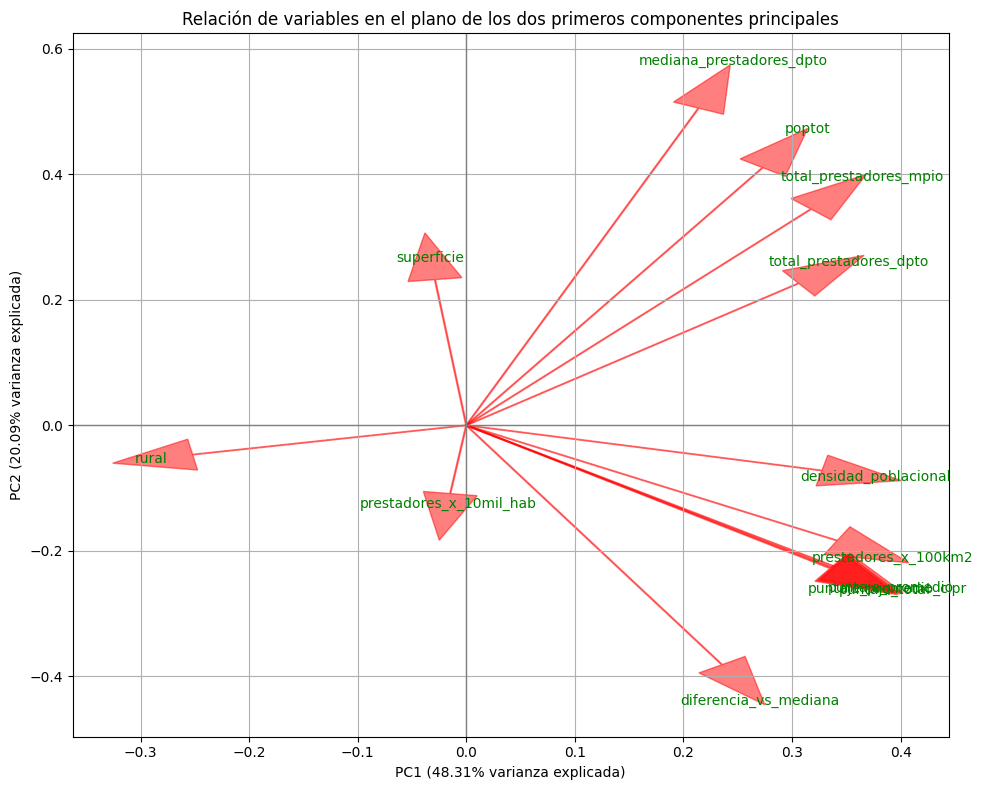

In [176]:


# 1. Seleccionar variables numéricas
variables_numericas = df_tipo_joined_clustered_final.select_dtypes(include=[np.number])

# 2. Eliminar filas con NaNs
variables_numericas = variables_numericas.dropna()

# 3. Escalado
X_scaled = StandardScaler().fit_transform(variables_numericas)

# 4. PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 5. Cargar componentes
componentes = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=variables_numericas.columns
)

# 6. Varianza explicada
var_exp_PC1 = pca.explained_variance_ratio_[0] * 100
var_exp_PC2 = pca.explained_variance_ratio_[1] * 100

# 7. Graficar
plt.figure(figsize=(10, 8))
for var in componentes.index:
    plt.arrow(0, 0, componentes.loc[var, 'PC1'], componentes.loc[var, 'PC2'],
              color='r', alpha=0.5, head_width=0.05)
    plt.text(componentes.loc[var, 'PC1']*1.15, componentes.loc[var, 'PC2']*1.15,
             var, color='g', ha='center', va='center')

plt.xlabel(f'PC1 ({var_exp_PC1:.2f}% varianza explicada)')
plt.ylabel(f'PC2 ({var_exp_PC2:.2f}% varianza explicada)')
plt.title('Relación de variables en el plano de los dos primeros componentes principales')
plt.grid()
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.tight_layout()
plt.show()


arbol de desición y diagrama de decisión 

In [177]:
df_model_final.columns

Index(['muni_nombre', 'nivel', 'total_prestadores_mpio',
       'total_prestadores_dpto', 'mediana_prestadores_dpto',
       'diferencia_vs_mediana', 'superficie', 'poptot', 'rural',
       'prestadores_x_10mil_hab', 'prestadores_x_100km2',
       'puntaje_prestadores_x_10mil_hab', 'puntaje_prestadores_x_100km2',
       'puntaje_diferencia_vs_mediana', 'puntaje_total', 'puntaje_promedio',
       'puntaje_promedio_clpr', 'densidad_poblacional', 'caracter',
       'clase_persona', 'naju_nombre', 'municipio pdet', 'municipio zomac',
       'municipio pnis', 'municipio pnsr antes 2023', 'municipio pnsr 2023',
       'municipio pnsr 2024', 'clasificacion_cobertura',
       'clasificacion_cobertura_clpr', 'clasificacion_densidad'],
      dtype='object')

In [178]:
df_model_final

,muni_nombre,nivel,total_prestadores_mpio,total_prestadores_dpto,mediana_prestadores_dpto,diferencia_vs_mediana,superficie,poptot,rural,prestadores_x_10mil_hab,...,naju_nombre,municipio pdet,municipio zomac,municipio pnis,municipio pnsr antes 2023,municipio pnsr 2023,municipio pnsr 2024,clasificacion_cobertura,clasificacion_cobertura_clpr,clasificacion_densidad
0,abejorral,1.0,9.461538,8677.846154,7.000000,2.461538,497.6,21622.0,56.7,4.375885,...,privada,no,si,no,no,si,si,Cobertura media alta,Cobertura alta,Baja densidad
1,abrego,1.0,8.384615,1060.230769,2.769231,5.615385,1507.4,36177.0,47.3,2.317665,...,privada,no,no,si,no,si,no,Cobertura media baja,Cobertura alta,Baja densidad
2,acacias,1.0,53.769231,511.923077,2.615385,51.153846,1086.4,97925.0,24.4,5.490858,...,privada,no,no,no,no,no,no,Cobertura alta,Cobertura alta,Baja densidad
3,acandi,NaN,1.000000,115.000000,1.250000,-0.250000,800.7,16096.0,56.1,0.621272,...,privada,si,si,si,si,si,si,Cobertura baja,Cobertura baja,Baja densidad
4,acevedo,1.0,3.400000,749.000000,3.400000,0.000000,537.1,27418.0,82.4,1.240061,...,privada,no,si,no,no,si,si,Cobertura media baja,Cobertura alta,Baja densidad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,zaragoza,NaN,7.222222,9119.666667,7.222222,0.000000,1277.4,26392.0,49.1,2.736519,...,privada,si,si,si,si,si,si,Cobertura media baja,Cobertura alta,Baja densidad
908,zarzal,2.0,18.696970,1006.878788,7.424242,11.272727,365.9,43252.0,22.8,4.322799,...,privada,no,no,no,no,no,no,Cobertura media alta,Cobertura alta,Baja densidad
909,zetaquira,1.0,1.000000,779.000000,1.500000,-0.500000,226.7,4996.0,70.6,2.001601,...,privada,no,no,no,no,si,no,Cobertura media baja,Cobertura media baja,Baja densidad
910,zipaquira,2.0,136.403315,1985.917127,5.370166,131.033149,204.9,165473.0,14.5,8.243237,...,privada,no,no,no,no,no,no,Cobertura alta,Cobertura alta,Media baja


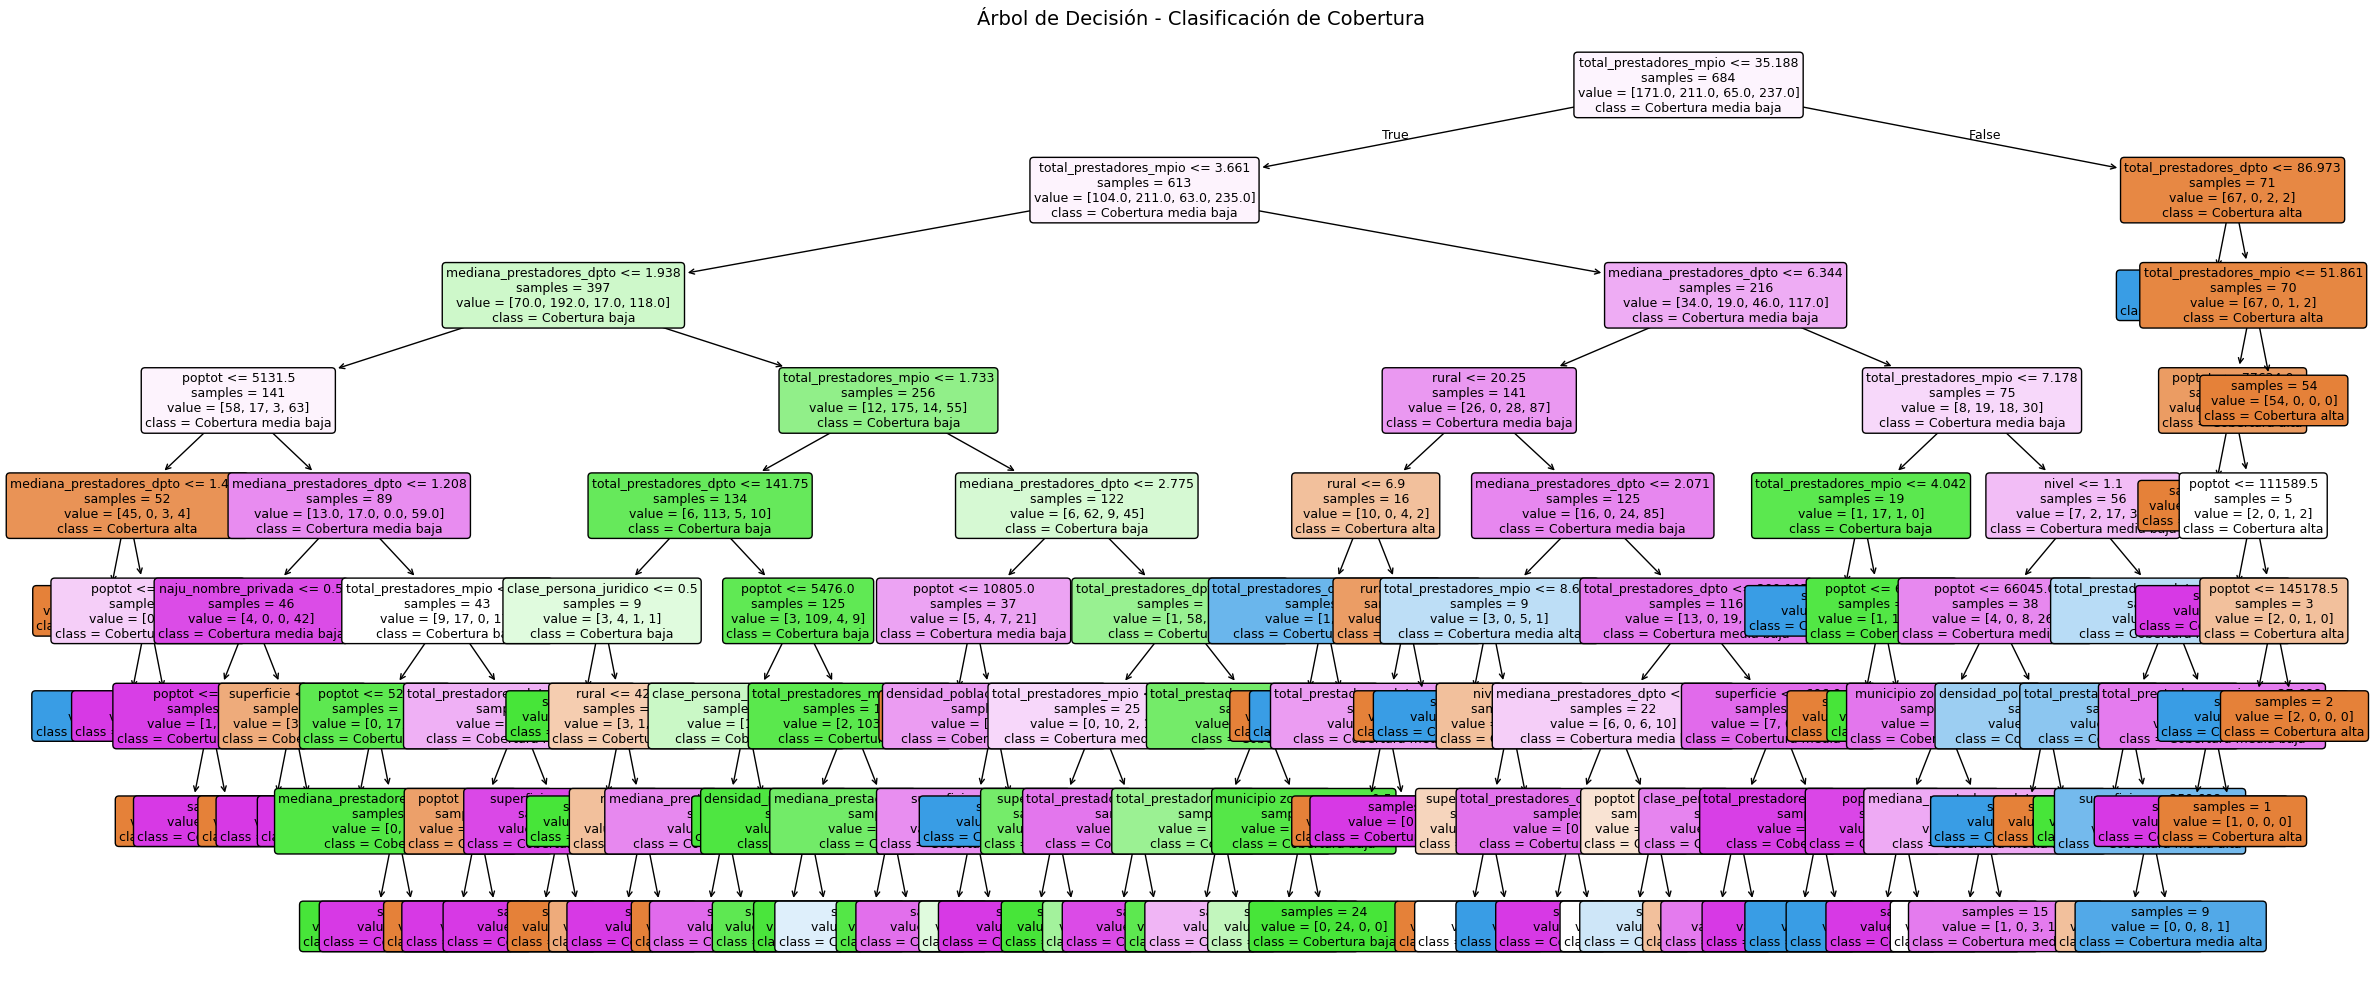

In [182]:

from sklearn.tree import DecisionTreeClassifier, plot_tree


# Separar X e y
X = df_model_final.drop(columns=['puntaje_promedio_clpr','clasificacion_cobertura_clpr','diferencia_vs_mediana','caracter','puntaje_prestadores_x_10mil_hab', 'puntaje_prestadores_x_100km2',
       'puntaje_diferencia_vs_mediana', 'puntaje_total', 'puntaje_promedio','clasificacion_cobertura', 'muni_nombre',"puntaje_total",'prestadores_x_10mil_hab', 'prestadores_x_100km2',
       'puntaje_prestadores_x_10mil_hab', 'puntaje_prestadores_x_100km2','puntaje_diferencia_vs_mediana'])
y = df_model_final['clasificacion_cobertura']

# Separar por tipo de variable
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Preprocesamiento: numéricas pasan, categóricas con OneHot
preprocessor = ColumnTransformer([
    ('num', 'passthrough', numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Pipeline completo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=8, random_state=42))
])

# Entrenar
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
pipeline.fit(X_train, y_train)

# Nombres de columnas tras OneHot
encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat']
encoded_cat_cols = encoder.get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(encoded_cat_cols)


plt.figure(figsize=(24, 10))  
plot_tree(
    pipeline.named_steps['classifier'],
    feature_names=all_feature_names,
    class_names=pipeline.named_steps['classifier'].classes_,
    filled=True,
    rounded=True,
    impurity=False,          
    fontsize=9               
)
plt.title("Árbol de Decisión - Clasificación de Cobertura", fontsize=14)
plt.tight_layout()
plt.show()


In [183]:
df_tipo_joined_clustered

,depa_nombre,muni_nombre,codigo_habilitacion,nombre_prestador,tido_codigo,nits_nit,razon_social,clpr_codigo,clpr_nombre,ese,...,puntaje_prestadores_x_100km2,puntaje_diferencia_vs_mediana,puntaje_total,puntaje_promedio,clasificacion_cobertura,puntaje_promedio_clpr,clasificacion_cobertura_clpr,densidad_poblacional,clasificacion_densidad,cluster
0,amazonas,leticia,9100100148,alexander abel perez fabra,NaN,72291077,alexander abel perez fabra,2,profesional independiente,nan,...,0,5,5,6.22807,Cobertura media alta,5.0,Cobertura alta,9.740105,Baja densidad,0
1,amazonas,leticia,9100100147,alicia paola rubio cruz,NaN,1018433478,alicia paola rubio cruz,2,profesional independiente,nan,...,0,5,5,6.22807,Cobertura media alta,5.0,Cobertura alta,9.740105,Baja densidad,0
2,amazonas,leticia,9100100134,alvaro enrique leon lara,NaN,13803322,alvaro enrique leon lara,2,profesional independiente,nan,...,0,5,5,6.22807,Cobertura media alta,5.0,Cobertura alta,9.740105,Baja densidad,0
3,amazonas,leticia,9100100038,ana lucia diaz guevara,NaN,51782620,ana lucia diaz guevara,2,profesional independiente,no,...,0,5,5,6.22807,Cobertura media alta,5.0,Cobertura alta,9.740105,Baja densidad,0
4,amazonas,leticia,9100100107,andres felipe zapata hernandez,NaN,15877110,andres felipe zapata hernandez,2,profesional independiente,nan,...,0,5,5,6.22807,Cobertura media alta,5.0,Cobertura alta,9.740105,Baja densidad,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63139,vichada,puerto carreno,9900100110,magda liliana toro arias,NaN,21249103,magda liliana toro arias,2,profesional independiente,nan,...,0,5,5,5.00000,Cobertura media baja,5.0,Cobertura alta,1.885985,Baja densidad,0
63140,vichada,puerto carreno,9900100049,sandra patricia rojas guerrero,NaN,52030942,sandra patricia rojas guerrero,2,profesional independiente,nan,...,0,5,5,5.00000,Cobertura media baja,5.0,Cobertura alta,1.885985,Baja densidad,0
63141,vichada,puerto carreno,9900100153,victoria eugenia mejia villarreal,NaN,55312163,victoria eugenia mejia villarreal,2,profesional independiente,nan,...,0,5,5,5.00000,Cobertura media baja,5.0,Cobertura alta,1.885985,Baja densidad,0
63142,vichada,puerto carreno,9900100119,yafar jose dib bayuelo,NaN,11189583,yafar jose dib bayuelo,2,profesional independiente,nan,...,0,5,5,5.00000,Cobertura media baja,5.0,Cobertura alta,1.885985,Baja densidad,0


In [184]:
df_tipo_joined_clustered.to_csv(r'C:\Users\FranciscoOcampo\Desktop\IETS_challenge\df_tipo_joined_clustered.csv', index=False)
